In [1]:
from utils import *
from Kpca import kPCA
from pca import PCA
from utils import param_heatmap, param_scatter, decision_boundary_plot, ROC_curve, check_d

import pandas as pd
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
from pyod.models.ocsvm import OCSVM
from scipy.linalg import eigh
from sklearn.datasets import fetch_openml

methods = ['kPCA','PCA','ParzenWindow','OCSVM']

# Replace 'delimiter_here' with '\t' if your file is tab-delimited, or ' ' if it is space-delimited
df = pd.read_csv('test sets/square.csv', delim_whitespace=True, header=None, names=['x', 'y'])

# Display the first few rows to verify it looks correct
print(df.head())


      x     y
0  1.79  0.59
1  0.48  1.33
2  1.64  0.55
3  0.49  2.04
4  2.56  1.17


C:\Users\vahed\AppData\Local\Temp\ipykernel_36212\4211514721.py:17: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv('test sets/square.csv', delim_whitespace=True, header=None, names=['x', 'y'])


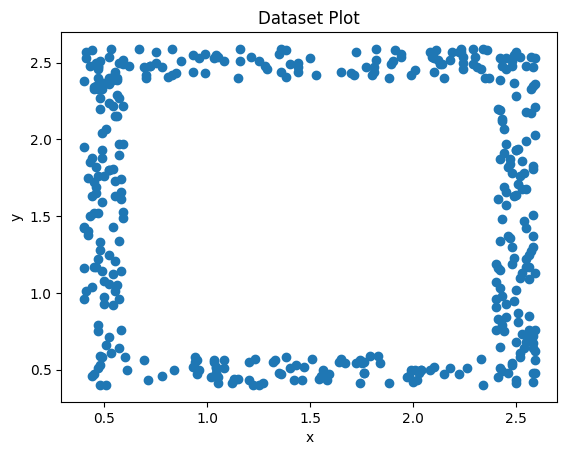

In [2]:
import matplotlib.pyplot as plt

# Plotting the dataset
plt.scatter(df['x'], df['y'])
plt.title('Dataset Plot')
plt.xlabel('x')
plt.ylabel('y')
plt.show()


In [3]:
# Data Prepration
from sklearn.model_selection import train_test_split

# Assuming df_named_columns is your dataset loaded into a pandas DataFrame
X = df[['x', 'y']]  # Features
# If you had a target variable, it would be something like y = df['target']

# Split the dataset into training and testing sets
# X_train, X_test, Y_train, Y_test = train_test_split(df['x'], df['y'], test_size=0.2, random_state=42)
X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)

x_train=X_train.to_numpy()
x_test=X_test.to_numpy()
y_train=np.ones(x_train.shape[0])
y_test=np.ones(x_test.shape[0])


test_size = x_test.shape[0]
idx = np.random.randint(0,test_size, int(test_size/2))
x_val = x_test[idx]
y_val = y_test[idx]
x_test = x_test[~idx]
y_test = y_test[~idx]
# X_train and X_eval are now your training and evaluation sets


## KPCA

In [20]:
num_search = 10 # Number of Parameters to search in the given interval
models = []
scores = []
test_aucs = []

# best_sigma = 0.4
# best_q = 40
# model = kPCA(q = int(best_q), sigma = best_sigma)
# model.fit(x_train) #still using model data
# test_scores = model.decision_function(x_test)
# scores.append(test_scores)
# test_auc = metrics.roc_auc_score(y_test,test_scores)
# test_aucs.append(test_auc)
# print('dataset:Square method:{',methods[0],'} best params:',  '{q:',best_q,'sigma:',round(best_sigma,4),'} val auc:', round(val_auc,4),'  test auc:',round(test_auc,4))
# print('dataset:Square method:{',methods[0],'} best params:',  '{q:',best_q,'sigma:',round(best_sigma,4),'}')
# models.append(model)

sigmas = np.array([0.05, 0.1, 0.4])
qs = np.array([0, 40])
num_params = num_search

gridsearch = np.zeros((len(sigmas)*len(qs),2)) #sigma, q, auc for each run
mesh = np.zeros((len(qs), len(sigmas)))

#perform gridsearch
run = 0
i= 0
for sigma in sigmas:
    j = 0
    for q in qs:
        model = kPCA(q = q, sigma = sigma)
        model.fit(x_train)
        gridsearch[run,:]= np.asarray([sigma,q])
        run += 1
        j += 1
        models.append(model)
    i += 1

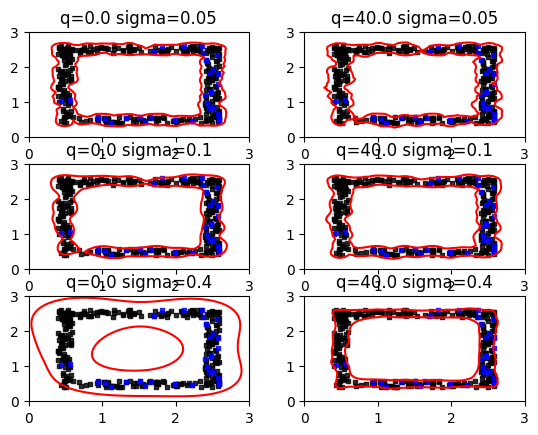

In [21]:
# decision_boundary_plot(x_train, X_test, y_test, [model],methods[0])
colors = ['g','r','b','m']
#fig, axs = plt.subplots(2,2,figsize=(10,10))
fig, axs = plt.subplots(len(sigmas),len(qs))
an_idx = np.where(y_test == 1)
bg_idx = np.where(y_test == 0)

xsteps = 50
ysteps = 50
xmin = np.min(df['x'].to_numpy())-.4
ymin = np.min(df['y'].to_numpy())-.4
xmax = np.max(df['x'].to_numpy())+.4
ymax = np.max(df['y'].to_numpy())+.4

xmin = 0
ymin = 0
xmax = 3
ymax = 3

xx,yy = np.meshgrid(np.linspace(xmin,xmax,xsteps), np.linspace(ymin,ymax,ysteps))
grid_dims = xx.shape
xx_f = np.expand_dims(xx.flatten(),axis=1)
yy_f = np.expand_dims(yy.flatten(),axis=1)
grid_list = np.concatenate((xx_f,yy_f),axis = 1)


axs_ = np.reshape(axs,len(models))
for i in range(len(models)):
    axs_[i].scatter(x_train[:,0], x_train[:,1],s=10,label = None, color = 'k',marker='s', edgecolors='k',alpha = 0.8)
    axs_[i].scatter(x_test[:,0], x_test[:,1],s=10,label = None, color = 'b',marker='s', edgecolors='b',alpha = 0.8)

    # axs_[i].scatter(x_test[bg_idx,0], x_test[bg_idx,1],s=10,label = None, color = 'b',marker='s', edgecolors='b',alpha = 0.5)
    # axs_[i].scatter(x_test[an_idx,0],x_test[an_idx,1], s=10,label = None, color = 'r',marker='s', edgecolors='r',alpha = 0.5)

    grid_errs = np.reshape(np.expand_dims(models[i].decision_function(grid_list),axis=1),grid_dims)

    bgval_idx = np.where(y_val == 1)
    scores = models[i].decision_function(x_val)
    fixed = np.max(scores[bgval_idx])
    cntr1 = axs_[i].contour(xx,yy,grid_errs,[fixed],colors=colors[1])
    #axs_[i].axis('off')
    axs_[i].set_xlim(xmin,xmax)
    axs_[i].set_ylim(ymin,ymax)
    axs_[i].set_title(f'q={gridsearch[i, 1]} sigma={gridsearch[i, 0]}')
    plt.subplots_adjust(wspace=0.25, hspace=0.25)

## PCA

In [38]:
num_search = 10 # Number of Parameters to search in the given interval
models = []
scores = []
test_aucs = []

best_q = 1
model = PCA(q = int(best_q))
model.fit(x_train) #still using model data
test_scores = model.decision_function(x_test)
scores.append(test_scores)
# test_auc = metrics.roc_auc_score(y_test,test_scores)
# test_aucs.append(test_auc)
# print('dataset:Square method:{',methods[0],'} best params:',  '{q:',best_q,'sigma:',round(best_sigma,4),'} val auc:', round(val_auc,4),'  test auc:',round(test_auc,4))
print('dataset:Square method:{',methods[1],'} best params:',  '{q:',best_q,'}')
models.append(model)


dataset:Square method:{ PCA } best params: {q: 1 }


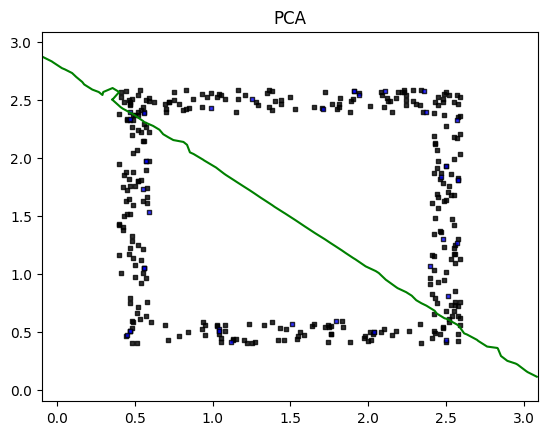

In [39]:
# decision_boundary_plot(x_train, X_test, y_test, [model],methods[0])
colors = ['g','r','b','m']
#fig, axs = plt.subplots(2,2,figsize=(10,10))
fig, axs = plt.subplots(1,1)
an_idx = np.where(y_test == 1)
bg_idx = np.where(y_test == 0)

xsteps = 50
ysteps = 50
xmin = np.min(df['x'].to_numpy())-.5
ymin = np.min(df['y'].to_numpy())-.5
xmax = np.max(df['x'].to_numpy())+.5
ymax = np.max(df['y'].to_numpy())+.5


xx,yy = np.meshgrid(np.linspace(xmin,xmax,xsteps), np.linspace(ymin,ymax,ysteps))
grid_dims = xx.shape
xx_f = np.expand_dims(xx.flatten(),axis=1)
yy_f = np.expand_dims(yy.flatten(),axis=1)
grid_list = np.concatenate((xx_f,yy_f),axis = 1)


axs_ = np.reshape(axs,len(models))
for i in range(len(models)):
    axs_[i].scatter(x_train[:,0], x_train[:,1],s=10,label = None, color = 'k',marker='s', edgecolors='k',alpha = 0.8)
    axs_[i].scatter(x_test[:,0], x_test[:,1],s=10,label = None, color = 'b',marker='s', edgecolors='k',alpha = 0.8)

    # axs_[i].scatter(x_test[bg_idx,0], x_test[bg_idx,1],s=10,label = None, color = 'b',marker='s', edgecolors='b',alpha = 0.5)
    # axs_[i].scatter(x_test[an_idx,0],x_test[an_idx,1], s=10,label = None, color = 'r',marker='s', edgecolors='r',alpha = 0.5)

    grid_errs = np.reshape(np.expand_dims(models[i].decision_function(grid_list),axis=1),grid_dims)

    bgval_idx = np.where(y_val == 1)
    scores = models[i].decision_function(x_val)
    fixed = np.max(scores[bgval_idx])
    cntr1 = axs_[i].contour(xx,yy,grid_errs,[fixed],colors=colors[i])
    #axs_[i].axis('off')
    axs_[i].set_xlim(xmin,xmax)
    axs_[i].set_ylim(ymin,ymax)
    axs_[i].set_title(methods[1])
    plt.subplots_adjust(wspace=0.25, hspace=0.25)

## Parzen Window

In [41]:
num_search = 10 # Number of Parameters to search in the given interval
models = []
scores = []
test_aucs = []

best_sigma = 0.05
best_q = 0
model = kPCA(q = int(best_q), sigma = best_sigma)
model.fit(x_train) #still using model data
test_scores = model.decision_function(x_test)
scores.append(test_scores)
# test_auc = metrics.roc_auc_score(y_test,test_scores)
# test_aucs.append(test_auc)
# print('dataset:Square method:{',methods[0],'} best params:',  '{q:',best_q,'sigma:',round(best_sigma,4),'} val auc:', round(val_auc,4),'  test auc:',round(test_auc,4))
print('dataset:Square method:{',methods[2],'} best params:',  '{q:',best_q,'sigma:',round(best_sigma,4),'}')
models.append(model)

dataset:Square method:{ ParzenWindow } best params: {q: 0 sigma: 0.05 }


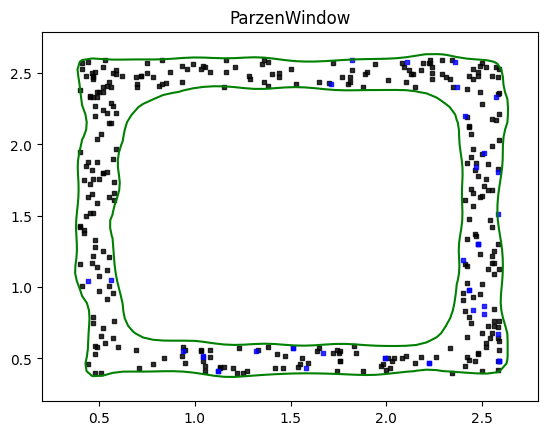

In [7]:
# decision_boundary_plot(x_train, X_test, y_test, [model],methods[0])
colors = ['g','r','b','m']
#fig, axs = plt.subplots(2,2,figsize=(10,10))
fig, axs = plt.subplots(1,1)
an_idx = np.where(y_test == 1)
bg_idx = np.where(y_test == 0)

xsteps = 50
ysteps = 50
xmin = np.min(df['x'].to_numpy())-.2
ymin = np.min(df['y'].to_numpy())-.2
xmax = np.max(df['x'].to_numpy())+.2
ymax = np.max(df['y'].to_numpy())+.2


xx,yy = np.meshgrid(np.linspace(xmin,xmax,xsteps), np.linspace(ymin,ymax,ysteps))
grid_dims = xx.shape
xx_f = np.expand_dims(xx.flatten(),axis=1)
yy_f = np.expand_dims(yy.flatten(),axis=1)
grid_list = np.concatenate((xx_f,yy_f),axis = 1)


axs_ = np.reshape(axs,len(models))
for i in range(len(models)):
    axs_[i].scatter(x_train[:,0], x_train[:,1],s=10,label = None, color = 'k',marker='s', edgecolors='k',alpha = 0.8)
    axs_[i].scatter(x_test[:,0], x_test[:,1],s=10,label = None, color = 'b',marker='s', edgecolors='b',alpha = 0.8)

    # axs_[i].scatter(x_test[bg_idx,0], x_test[bg_idx,1],s=10,label = None, color = 'b',marker='s', edgecolors='b',alpha = 0.5)
    # axs_[i].scatter(x_test[an_idx,0],x_test[an_idx,1], s=10,label = None, color = 'r',marker='s', edgecolors='r',alpha = 0.5)

    grid_errs = np.reshape(np.expand_dims(models[i].decision_function(grid_list),axis=1),grid_dims)

    bgval_idx = np.where(y_val == 1)
    scores = models[i].decision_function(x_val)
    fixed = np.max(scores[bgval_idx])
    cntr1 = axs_[i].contour(xx,yy,grid_errs,[fixed],colors=colors[i])
    #axs_[i].axis('off')
    axs_[i].set_xlim(xmin,xmax)
    axs_[i].set_ylim(ymin,ymax)
    axs_[i].set_title(methods[2])
    plt.subplots_adjust(wspace=0.25, hspace=0.25)

## OCSVM

In [45]:
num_search = 10 # Number of Parameters to search in the given interval
models = []
scores = []
test_aucs = []

best_sigma = 0.05
best_q = 0
nu=0.01
sigma=0.05
gamma = 0.5/(sigma*sigma)
model = OCSVM(nu = nu, gamma = gamma)
model.fit(x_train) #still using model data
test_scores = model.decision_function(x_test)
scores.append(test_scores)
# test_auc = metrics.roc_auc_score(y_test,test_scores)
# test_aucs.append(test_auc)
# print('dataset:Square method:{',methods[0],'} best params:',  '{q:',best_q,'sigma:',round(best_sigma,4),'} val auc:', round(val_auc,4),'  test auc:',round(test_auc,4))
# print('dataset:Square method:{',methods[2],'} best params:',  '{q:',best_q,'sigma:',round(best_sigma,4),'}')
models.append(model)

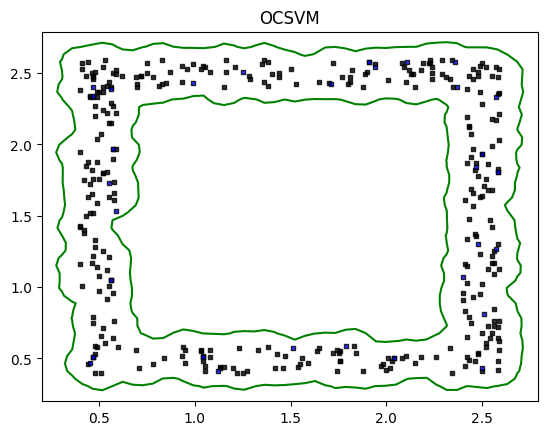

In [46]:
# decision_boundary_plot(x_train, X_test, y_test, [model],methods[0])
colors = ['g','r','b','m']
#fig, axs = plt.subplots(2,2,figsize=(10,10))
fig, axs = plt.subplots(1,1)
an_idx = np.where(y_test == 1)
bg_idx = np.where(y_test == 0)

xsteps = 50
ysteps = 50
xmin = np.min(df['x'].to_numpy())-.2
ymin = np.min(df['y'].to_numpy())-.2
xmax = np.max(df['x'].to_numpy())+.2
ymax = np.max(df['y'].to_numpy())+.2


xx,yy = np.meshgrid(np.linspace(xmin,xmax,xsteps), np.linspace(ymin,ymax,ysteps))
grid_dims = xx.shape
xx_f = np.expand_dims(xx.flatten(),axis=1)
yy_f = np.expand_dims(yy.flatten(),axis=1)
grid_list = np.concatenate((xx_f,yy_f),axis = 1)


axs_ = np.reshape(axs,len(models))
for i in range(len(models)):
    axs_[i].scatter(x_train[:,0], x_train[:,1],s=10,label = None, color = 'k',marker='s', edgecolors='k',alpha = 0.8)
    axs_[i].scatter(x_test[:,0], x_test[:,1],s=10,label = None, color = 'b',marker='s', edgecolors='k',alpha = 0.8)

    # axs_[i].scatter(x_test[bg_idx,0], x_test[bg_idx,1],s=10,label = None, color = 'b',marker='s', edgecolors='b',alpha = 0.5)
    # axs_[i].scatter(x_test[an_idx,0],x_test[an_idx,1], s=10,label = None, color = 'r',marker='s', edgecolors='r',alpha = 0.5)

    grid_errs = np.reshape(np.expand_dims(models[i].decision_function(grid_list),axis=1),grid_dims)

    bgval_idx = np.where(y_val == 1)
    scores = models[i].decision_function(x_val)
    fixed = np.max(scores[bgval_idx])
    cntr1 = axs_[i].contour(xx,yy,grid_errs,[fixed],colors=colors[i])
    #axs_[i].axis('off')
    axs_[i].set_xlim(xmin,xmax)
    axs_[i].set_ylim(ymin,ymax)
    axs_[i].set_title(methods[3])
    plt.subplots_adjust(wspace=0.25, hspace=0.25)